In [13]:
using LinearAlgebra
using Distributions
using StatsBase
using Printf
using HDF5
using JSON
using ProgressMeter
using Plots
using LaTeXStrings
using BenchmarkTools

In [63]:
Δ = 0.1
x = -2π:Δ:2π-Δ
y = -2π:Δ:2π-Δ
xx = ones(length(y)) * x';
yy = y * ones(length(x))';

Nx = length(x);
dx = Δ;
grad = diagm(-(Nx - 1) => [+1/2],
             -1 => -(1/2) * ones(Nx - 1),
             +1 => +(1/2) * ones(Nx - 1),
             +(Nx - 1) => [-(1/2)]) ./ dx;

lap = diagm(-(Nx - 1) => [1],
            -1 => 1 * ones(Nx - 1),
            0 => -2 * ones(Nx),
            +1 => 1 * ones(Nx - 1),
            +(Nx - 1) => [1]) ./ dx^2;

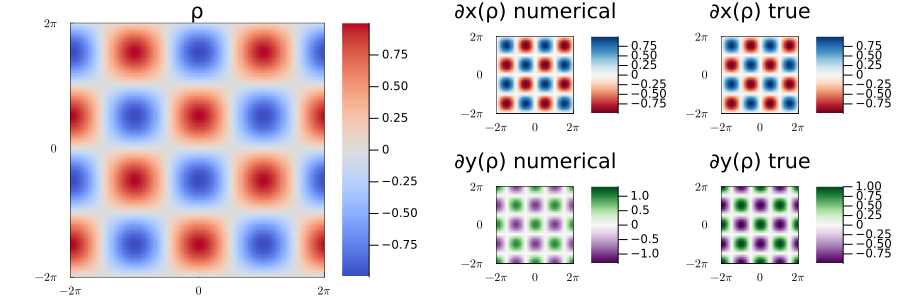

In [64]:
rho = @. cos(xx) * sin(yy);
gradx_rho = rho * grad'
grady_rho = grad * rho
gradx_rho_true = @. -sin(xx) * sin(yy)
grady_rho_true = @. cos(xx) * cos(yy)

h0 = heatmap(x, y, rho, cmap=:coolwarm, title="ρ")
h1 = heatmap(x, y, gradx_rho, cmap=:RdBu, title="∂x(ρ) numerical")
h2 = heatmap(x, y, gradx_rho_true, cmap=:RdBu, title="∂x(ρ) true")
h3 = heatmap(x, y, grady_rho, cmap=:PRGn, title="∂y(ρ) numerical")
h4 = heatmap(x, y, grady_rho_true, cmap=:PRGn, title="∂y(ρ) true")
l = @layout([a [b c; d e]])
plot(h0, h1, h2, h3, h4, layout=l, size=(900, 300),
     thickness_scaling=1.0, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))


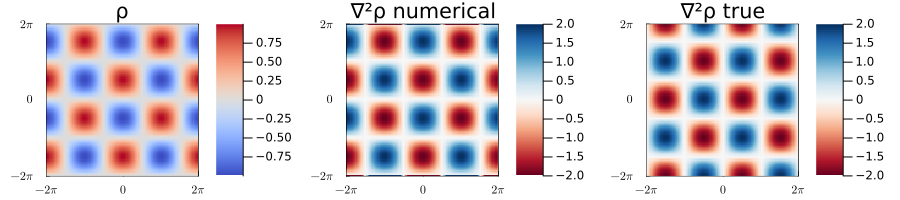

In [65]:
lap_rho = (lap * rho')' + lap * rho
lap_rho_true = @. -2 * sin(xx) * cos(yy)

h0 = heatmap(x, y, rho, cmap=:coolwarm, title="ρ")
h1 = heatmap(x, y, lap_rho, cmap=:RdBu, title="∇²ρ numerical", clim=(-2, 2))
h2 = heatmap(x, y, lap_rho_true, cmap=:RdBu, title="∇²ρ true", clim=(-2, 2))
l = @layout([a b c])
plot(h0, h1, h2, layout=l, size=(900, 200),
     thickness_scaling=1.0, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))


In [66]:
function calc_grad(field::Array{T, 2}, dx::T, periodic::Bool) where T<:AbstractFloat
    ∇xfield = similar(field)
    ∇yfield = similar(field)
    Ny, Nx = size(field)

    # central differences in center region
    for x in 2:Nx-1
        for y in 2:Ny-1
            ∇xfield[y, x] = (field[y, x+1] - field[y, x-1]) / 2
            ∇yfield[y, x] = (field[y+1, x] - field[y-1, x]) / 2
        end
    end

    if periodic # do central differences at edges
        ### corners ###
        # bottom left
        ∇xfield[1, 1] = (field[1, 2] - field[1, Nx]) / 2
        ∇yfield[1, 1] = (field[2, 1] - field[Ny, 1]) / 2

        # bottom right
        ∇xfield[1, Nx] = (field[1, 1] - field[1, Nx-1]) / 2
        ∇yfield[1, Nx] = (field[2, Nx] - field[Ny, Nx]) / 2

        # top left
        ∇xfield[Ny, 1] = (field[Ny, 2] - field[Ny, Nx]) / 2
        ∇yfield[Ny, 1] = (field[1, 1] - field[Ny-1, 1]) / 2

        # top right
        ∇xfield[Ny, Nx] = (field[Ny, 1] - field[Ny, Nx-1]) / 2
        ∇yfield[Ny, Nx] = (field[1, Nx] - field[Ny-1, Nx]) / 2

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇xfield[y, 1] = (field[y, 2] - field[y, Nx]) / 2
            ∇yfield[y, 1] = (field[y+1, 1] - field[y-1, 1]) / 2
            # right
            ∇xfield[y, Nx] = (field[y, 1] - field[y, Nx-1]) / 2
            ∇yfield[y, Nx] = (field[y+1, Nx] - field[y-1, Nx]) / 2
        end
        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇xfield[1, x] = (field[1, x+1] - field[1, x-1]) / 2
            ∇yfield[1, x] = (field[2, x] - field[Ny, x]) / 2
            # top
            ∇xfield[Ny, x] = (field[Ny, x+1] - field[Ny, x-1]) / 2
            ∇yfield[Ny, x] = (field[1, x] - field[Ny-1, x]) / 2
        end
    else # do forward/backward differences at ends
        ### corners ###
        # bottom left
        ∇xfield[1, 1] = field[1, 2] - field[1, 1]
        ∇yfield[1, 1] = field[2, 1] - field[1, 1]

        # bottom right
        ∇xfield[1, Nx] = field[1, Nx] - field[1, Nx-1]
        ∇yfield[1, Nx] = field[2, Nx] - field[1, Nx]

        # top left
        ∇xfield[Ny, 1] = field[Ny, 2] - field[Ny, 1]
        ∇yfield[Ny, 1] = field[Ny, 1] - field[Ny-1, 1]

        # top right
        ∇xfield[Ny, Nx] = field[Ny, Nx] - field[Ny, Nx-1]
        ∇yfield[Ny, Nx] = field[Ny, Nx] - field[Ny-1, Nx]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇xfield[y, 1] = field[y, 2] - field[y, 1]
            ∇yfield[y, 1] = (field[y+1, 1] - field[y-1, 1]) / 2
            # right
            ∇xfield[y, Nx] = field[y, Nx] - field[y, Nx - 1]
            ∇yfield[y, Nx] = (field[y+1, Nx] - field[y-1, Nx]) / 2
        end
        #horizontal
        for x in 2:Nx-1
            # bottom
            ∇xfield[1, x] = (field[1, x+1] - field[1, x-1]) / 2
            ∇yfield[1, x] = field[2, x] - field[1, x]  # forward
            # top
            ∇xfield[Ny, x] = (field[Ny, x+1] - field[Ny, x-1]) / 2
            ∇yfield[Ny, x] = field[Ny, x] - field[Ny-1, x]  # backward
        end
    end

    return ∇xfield ./ dx, ∇yfield ./ dx
end

function calc_lap(field::Array{T, 2}, dx::T, periodic::Bool) where T<:AbstractFloat
    ∇²field = similar(field)
    Ny, Nx = size(field)

    # central differences in center region
    # Do order: up, right, center, down, left
    for x in 2:Nx-1
        for y in 2:Ny-1
            ∇²field[y, x] = field[y+1, x] + field[y, x+1] - 4 * field[y, x] + field[y-1, x] + field[y, x-1]
        end
    end

    if periodic # do central differences at edges
        ### corners ###
        # bottom left
        ∇²field[1, 1] = field[2, 1] + field[1, 2] - 4 * field[1, 1] + field[Ny, 1] + field[1, Nx]

        # bottom right
        ∇²field[1, Nx] = field[2, Nx] + field[1, 1] - 4 * field[1, Nx] + field[Ny, Nx] + field[1, Nx-1]

        # top left
        ∇²field[Ny, 1] = field[1, 1] + field[Ny, 2] - 4 * field[Ny, 1] + field[Ny-1, 1] + field[Ny, Nx]

        # top right
        ∇²field[Ny, Nx] = field[1, Nx] + field[Ny, 1] - 4 * field[Ny, Nx] + field[Ny-1, Nx] + field[Ny, Nx-1]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇²field[y, 1] = field[y+1, 1] + field[y, 2] - 4 * field[y, 1] + field[y-1, 1] + field[y, Nx]
            # right
            ∇²field[y, Nx] = field[y+1, Nx] + field[y, 1] - 4 * field[y, Nx] + field[y-1, Nx] + field[y, Nx-1]
        end

        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇²field[1, x] = field[2, x] + field[1, x+1] - 4 * field[1, x] + field[Ny, x] + field[1, x-1]
            # top
            ∇²field[Ny, x] = field[1, x] + field[Ny, x+1] - 4 * field[Ny, x] + field[Ny-1, x] + field[Ny, x-1]
        end

    else # do forward/backward differences at edges
        ### corners ###
        # bottom left
        ∇²field[1, 1] = field[3, 1] - 2 * field[2, 1] + 2 * field[1, 1] - 2 * field[1, 2] + field[1, 3]

        # bottom right
        ∇²field[1, Nx] = field[1, Nx-2] - 2 * field[1, Nx-1] + 2 * field[1, Nx] - 2 * field[2, Nx] + field[3, Nx]

        # top left
        ∇²field[Ny, 1] = field[Ny-2, 1] - 2 * field[Ny-1, 1] + 2 * field[Ny, 1] - 2 * field[Ny, 2] + field[Ny, 3]

        # top right
        ∇²field[Ny, Nx] = field[Ny, Nx-2] - 2 * field[Ny, Nx-1] + 2 * field[Ny, Nx] - 2 * field[Ny-1, Nx] + field[Ny-2, Nx]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇²field[y, 1] = field[y+1, 1] - field[y, 1] + field[y-1, 1] - 2 * field[y, 2] + field[y, 3]
            # right
            ∇²field[y, Nx] = field[y+1, Nx] - field[y, Nx] + field[y-1, Nx] - 2 * field[y, Nx-1] + field[y, Nx-2]
        end

        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇²field[1, x] = field[1, x-1] - field[1, x] + field[1, x+1] - 2 * field[2, x] + field[3, x]
            # top
            ∇²field[Ny, x] = field[Ny, x-1] - field[Ny, x] + field[Ny, x+1] - 2 * field[Ny-1, x] + field[Ny-2, x]
        end
    end

    return ∇²field ./ dx^2
end

calc_lap (generic function with 1 method)

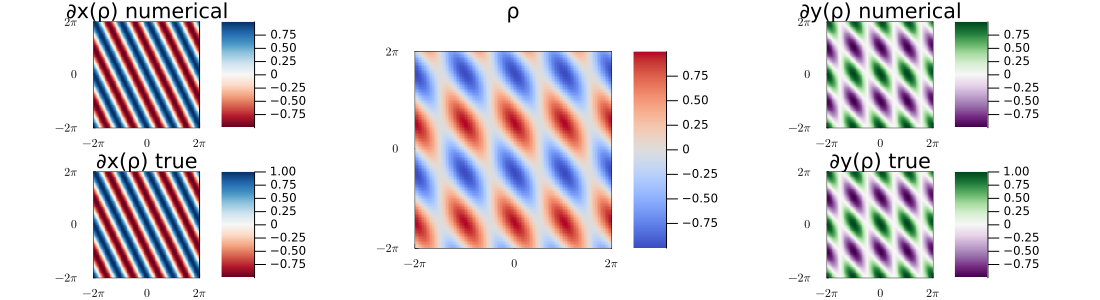

In [147]:
rho = @. cos(xx) * sin(yy + xx);
rhox, rhoy = calc_grad(rho, dx, false);
gradx_rho_true = @. cos(xx) * cos(xx + yy) - sin(xx) * sin(yy + xx)
grady_rho_true = @. cos(xx) * cos(xx + yy)

h0 = heatmap(x, y, rho, cmap=:coolwarm, title="ρ")
h1 = heatmap(x, y, rhox, cmap=:RdBu, title="∂x(ρ) numerical")
h2 = heatmap(x, y, gradx_rho_true, cmap=:RdBu, title="∂x(ρ) true")
h3 = heatmap(x, y, rhoy, cmap=:PRGn, title="∂y(ρ) numerical")
h4 = heatmap(x, y, grady_rho_true, cmap=:PRGn, title="∂y(ρ) true")
l = @layout([[a; b] c [d; e]])
plot(h1, h2, h0, h3, h4, layout=l, size=(1100, 300),
     thickness_scaling=1, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))


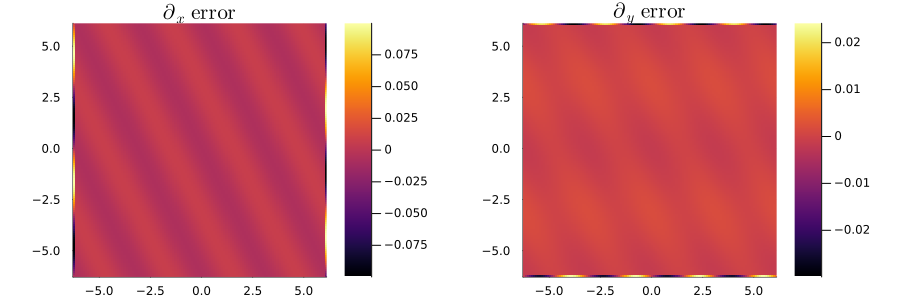

In [112]:
hy = heatmap(x, y, (rhoy - grady_rho_true), title=L"\partial_y \ \mathrm{error}")
hx = heatmap(x, y, (rhox - gradx_rho_true), title=L"\partial_x \ \mathrm{error}")

plot(hx, hy, layout=(1, 2), aspect_ratio=1, xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)), size=(900, 300))

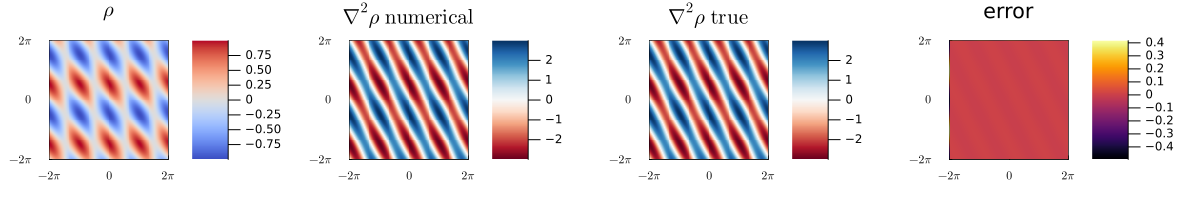

In [138]:
rho = @. cos(xx) * sin(yy + xx);
rholap = calc_lap(rho, dx, false);
lap_rho_true = @. -2 * cos(xx + yy) * sin(xx) - 3 * cos(xx) * sin(xx + yy)

h0 = heatmap(x, y, rho, cmap=:coolwarm, title=L"\rho")
h1 = heatmap(x, y, rholap, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{numerical}")
h2 = heatmap(x, y, lap_rho_true, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{true}")
h3 = heatmap(x, y, rholap - lap_rho_true, title="error")
l = @layout([a b c d])
plot(h0, h1, h2, h3, layout=l, size=(1200, 200),
     thickness_scaling=1.0, aspect_ratio=1, framestyle=:box,
     xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
     xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
     yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))
